# EDA: ZIP Code Impact on LAUSD School Performance

This notebook contains exploratory data analysis (EDA) focused on **ZIP code as a key contributing factor** to school performance prediction.

**Key Finding from Final Project**: ZIP code is the **4th most important feature (16.1% importance)** in the Random Forest model predicting school performance.

## 1. Data Loading and Preparation

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [25]:
# Load the data (same preprocessing as Final Project)
# Load CAASPP dataset
caaspp = pd.read_csv(
    "sb_ca2024_1_csv_v1.txt",
    delimiter="^",
    encoding="latin1",
    dtype={
        "County Code": str,
        "District Code": str,
        "School Code": str
    }
)

# Create CDSCode
caaspp["CDSCode"] = (
    caaspp["County Code"].str.zfill(2) +
    caaspp["District Code"].str.zfill(5) +
    caaspp["School Code"].str.zfill(7)
)

# Load budget/expenditure data
df = pd.read_csv("df_3_4_inner (1).csv")
df = df.loc[:, ~df.columns.str.contains(r"^Unnamed")]
df["CDSCODE"] = df["CDSCODE"].astype(str).str.zfill(14)
df["ZIP"] = pd.to_numeric(df["ZIP"], errors="coerce")

# Merge datasets
merged = df.merge(
    caaspp,
    left_on="CDSCODE",
    right_on="CDSCode",
    how="inner"
)

# Filter for All Students + ELA
filtered = merged[
    (merged["Student Group ID"] == 1) &
    (merged["Test ID"] == 1)
].copy()

# Convert score columns
filtered["Percentage Standard Met and Above"] = pd.to_numeric(
    filtered["Percentage Standard Met and Above"], errors="coerce"
)
filtered["Mean Scale Score"] = pd.to_numeric(
    filtered["Mean Scale Score"], errors="coerce"
)

# Aggregate to school level
school_perf = filtered.groupby("CDSCODE", as_index=False).agg({
    "Percentage Standard Met and Above": "mean",
    "Mean Scale Score": "mean"
})

school_perf.rename(columns={
    "Percentage Standard Met and Above": "Pct_Met_Above",
    "Mean Scale Score": "Mean_Score"
}, inplace=True)

# Merge with budget data
final = df.merge(school_perf, left_on="CDSCODE", right_on="CDSCODE", how="inner")

# Convert numeric columns
numeric_cols = [
    "Budget (incl c/o) FY24",
    "Expenditures FY24",
    "% Exp FY24",
    "Pct_Met_Above",
    "Mean_Score"
]

for col in numeric_cols:
    final[col] = pd.to_numeric(final[col], errors="coerce")

final_clean = final.dropna(subset=numeric_cols).copy()

print(f"Loaded {len(final_clean)} schools across {final_clean['ZIP'].nunique()} ZIP codes")
print(f"\nDataset shape: {final_clean.shape}")
print(f"\nZIP codes: {sorted(final_clean['ZIP'].unique())}")

Loaded 86 schools across 62 ZIP codes

Dataset shape: (86, 26)

ZIP codes: [90001, 90002, 90003, 90004, 90005, 90006, 90007, 90008, 90011, 90015, 90017, 90018, 90019, 90021, 90023, 90026, 90028, 90032, 90034, 90035, 90038, 90041, 90042, 90043, 90044, 90045, 90047, 90061, 90063, 90064, 90065, 90066, 90071, 90201, 90247, 90255, 90275, 90280, 90292, 90717, 90731, 90745, 90746, 91040, 91306, 91311, 91325, 91331, 91335, 91340, 91342, 91343, 91344, 91352, 91367, 91402, 91405, 91406, 91411, 91602, 91605, 91606]


## 2. Geographic Distribution Analysis

### 2.1 School Count and Performance by ZIP Code

In [26]:
# Aggregate by ZIP code
zip_summary = final_clean.groupby('ZIP').agg({
    'CDSCODE': 'count',
    'Pct_Met_Above': 'mean',
    'Mean_Score': 'mean',
    'Expenditures FY24': 'mean',
    'Budget (incl c/o) FY24': 'mean',
    '% Exp FY24': 'mean'
}).reset_index()

zip_summary.columns = ['ZIP', 'School_Count', 'Avg_Pct_Met_Above', 'Avg_Mean_Score', 
                        'Avg_Expenditures', 'Avg_Budget', 'Avg_Pct_Exp']

zip_summary = zip_summary.sort_values('Avg_Pct_Met_Above', ascending=False)

print("Top 10 Performing ZIP Codes:")
print(zip_summary.head(10))
print("\nBottom 10 Performing ZIP Codes:")
print(zip_summary.tail(10))

Top 10 Performing ZIP Codes:
      ZIP  School_Count  Avg_Pct_Met_Above  Avg_Mean_Score  Avg_Expenditures  \
26  90047             1          85.900000     2666.400000      4.779587e+06   
19  90035             1          68.356000     2603.975000      1.498121e+07   
48  91335             1          67.670000     2575.550000      1.773628e+07   
21  90041             2          64.957000     2556.875000      1.422795e+07   
36  90275             1          63.582500     2588.533333      1.474318e+07   
59  91602             1          62.465000     2578.166667      1.521605e+07   
4   90005             1          62.202500     2571.400000      1.446847e+07   
18  90034             1          59.012500     2571.633333      1.377768e+07   
52  91344             4          54.195000     2532.866667      1.206859e+07   
41  90745             3          47.083214     2522.094444      1.326471e+07   

    Avg_Budget  Avg_Pct_Exp  
26   5867719.0     0.814556  
19  15350962.0     0.975914  


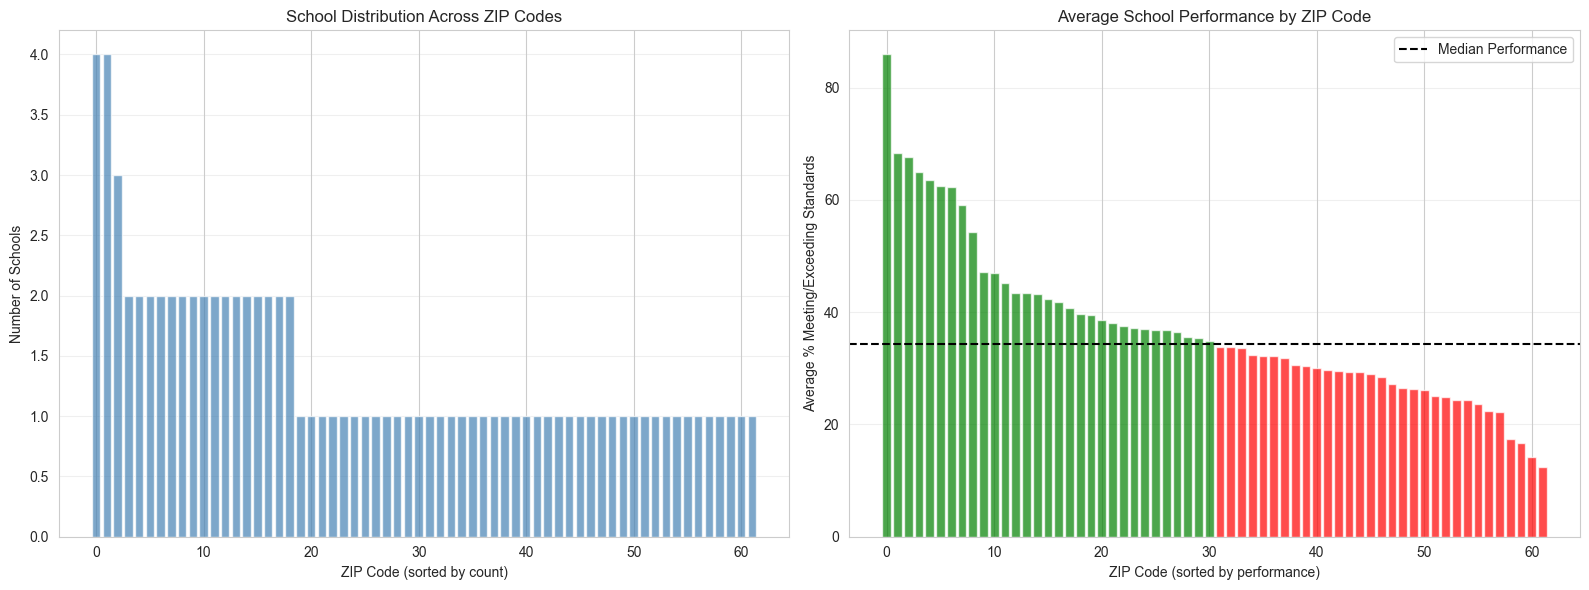


Performance Range: 12.5% to 85.9%
Difference: 73.4 percentage points


In [27]:
# Visualize school distribution by ZIP code
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: School count by ZIP
zip_summary_sorted = zip_summary.sort_values('School_Count', ascending=False)
axes[0].bar(range(len(zip_summary_sorted)), zip_summary_sorted['School_Count'], 
            color='steelblue', alpha=0.7)
axes[0].set_xlabel('ZIP Code (sorted by count)')
axes[0].set_ylabel('Number of Schools')
axes[0].set_title('School Distribution Across ZIP Codes')
axes[0].grid(axis='y', alpha=0.3)

# Right: Average performance by ZIP
colors = ['green' if x > zip_summary['Avg_Pct_Met_Above'].median() else 'red' 
          for x in zip_summary['Avg_Pct_Met_Above']]
axes[1].bar(range(len(zip_summary)), zip_summary['Avg_Pct_Met_Above'], 
            color=colors, alpha=0.7)
axes[1].axhline(zip_summary['Avg_Pct_Met_Above'].median(), color='black', 
                linestyle='--', label='Median Performance')
axes[1].set_xlabel('ZIP Code (sorted by performance)')
axes[1].set_ylabel('Average % Meeting/Exceeding Standards')
axes[1].set_title('Average School Performance by ZIP Code')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPerformance Range: {zip_summary['Avg_Pct_Met_Above'].min():.1f}% to {zip_summary['Avg_Pct_Met_Above'].max():.1f}%")
print(f"Difference: {zip_summary['Avg_Pct_Met_Above'].max() - zip_summary['Avg_Pct_Met_Above'].min():.1f} percentage points")

### 2.2 ZIP Code Performance Distribution (Box Plot)

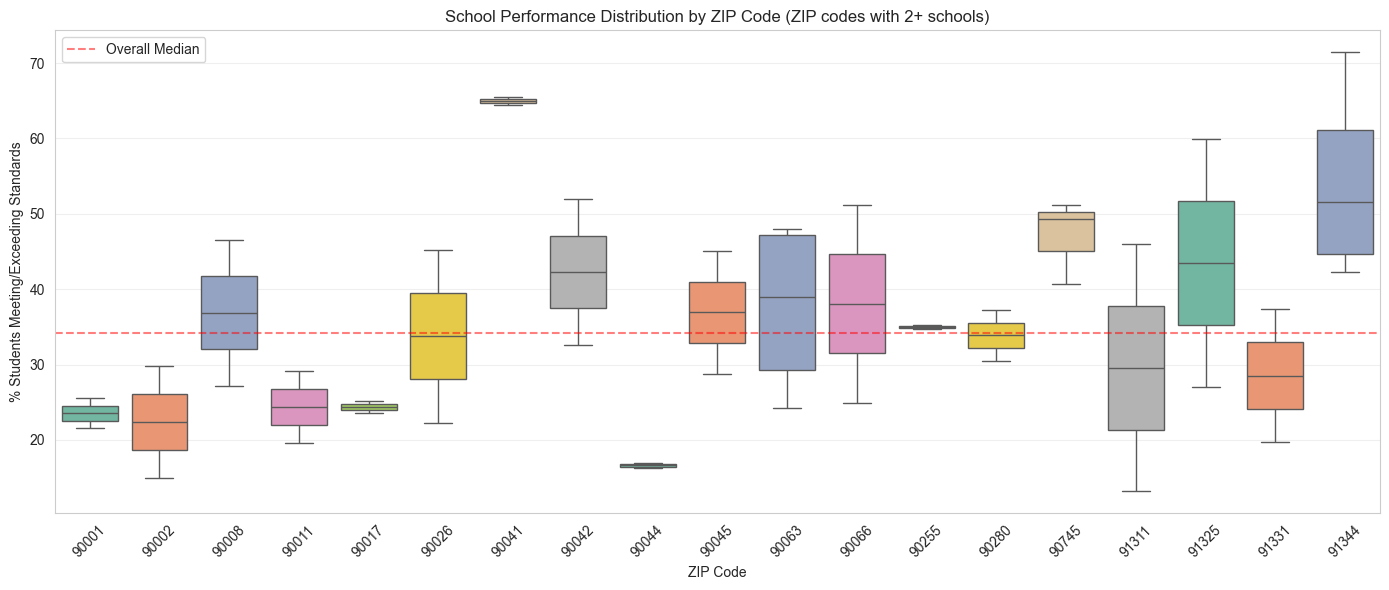

ZIP codes with multiple schools: 19
ZIP codes with single school: 43


In [28]:
# Box plot showing variation within ZIP codes
# Only show ZIP codes with multiple schools
zip_counts = final_clean['ZIP'].value_counts()
multi_school_zips = zip_counts[zip_counts > 1].index

data_multi = final_clean[final_clean['ZIP'].isin(multi_school_zips)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=data_multi, x='ZIP', y='Pct_Met_Above', palette='Set2')
plt.xticks(rotation=45)
plt.xlabel('ZIP Code')
plt.ylabel('% Students Meeting/Exceeding Standards')
plt.title('School Performance Distribution by ZIP Code (ZIP codes with 2+ schools)')
plt.axhline(final_clean['Pct_Met_Above'].median(), color='red', linestyle='--', 
            alpha=0.5, label='Overall Median')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ZIP codes with multiple schools: {len(multi_school_zips)}")
print(f"ZIP codes with single school: {len(zip_counts[zip_counts == 1])}")

## 3. Funding vs ZIP Code Analysis

### 3.1 Funding Disparities Across ZIP Codes

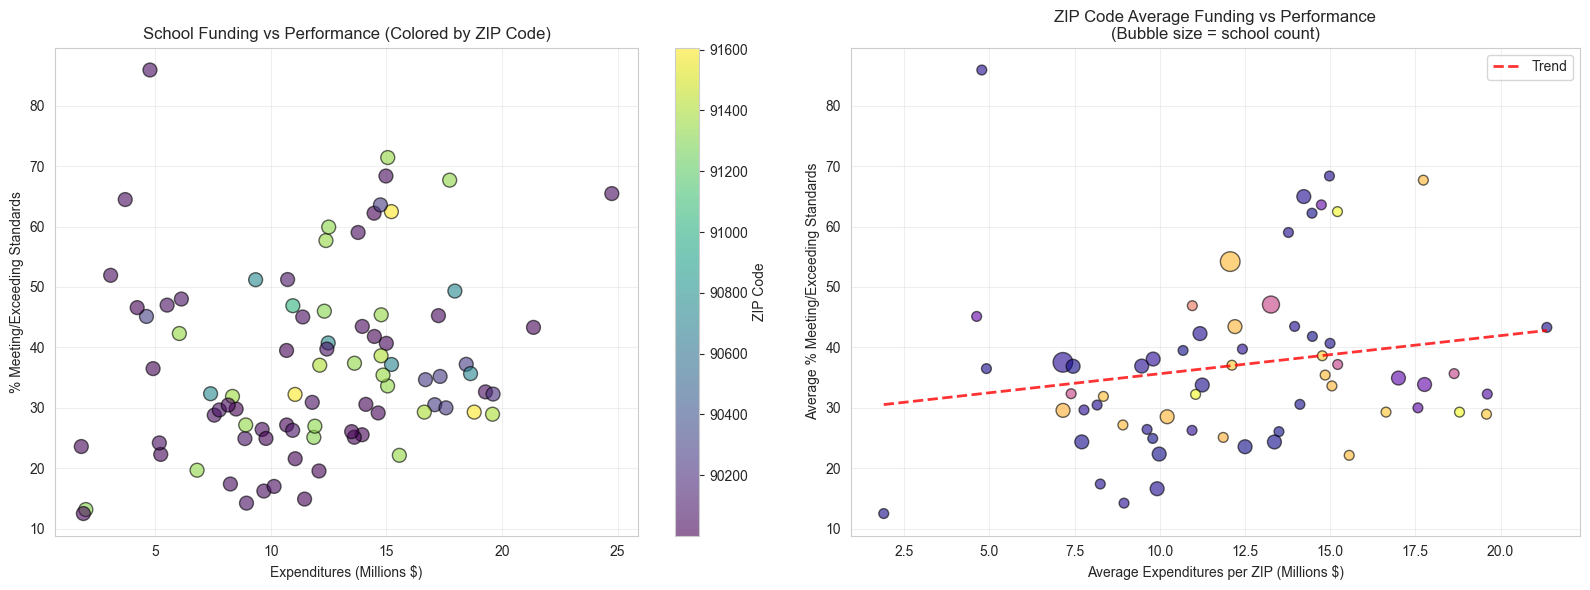


Correlation between average ZIP funding and performance: 0.181


In [29]:
# Scatter plot: Expenditures vs Performance, colored by ZIP
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Expenditures vs Performance
scatter = axes[0].scatter(final_clean['Expenditures FY24'] / 1e6, 
                          final_clean['Pct_Met_Above'],
                          c=final_clean['ZIP'], cmap='viridis', 
                          s=100, alpha=0.6, edgecolors='black')
axes[0].set_xlabel('Expenditures (Millions $)')
axes[0].set_ylabel('% Meeting/Exceeding Standards')
axes[0].set_title('School Funding vs Performance (Colored by ZIP Code)')
axes[0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='ZIP Code')

# Right: Average funding by ZIP code
axes[1].scatter(zip_summary['Avg_Expenditures'] / 1e6, 
                zip_summary['Avg_Pct_Met_Above'],
                s=zip_summary['School_Count'] * 50, 
                c=zip_summary['ZIP'], cmap='plasma',
                alpha=0.6, edgecolors='black')
axes[1].set_xlabel('Average Expenditures per ZIP (Millions $)')
axes[1].set_ylabel('Average % Meeting/Exceeding Standards')
axes[1].set_title('ZIP Code Average Funding vs Performance\n(Bubble size = school count)')
axes[1].grid(alpha=0.3)

# Add trend line
z = np.polyfit(zip_summary['Avg_Expenditures'] / 1e6, 
               zip_summary['Avg_Pct_Met_Above'], 1)
p = np.poly1d(z)
x_line = np.linspace(zip_summary['Avg_Expenditures'].min() / 1e6, 
                     zip_summary['Avg_Expenditures'].max() / 1e6, 100)
axes[1].plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label='Trend')
axes[1].legend()

plt.tight_layout()
plt.show()

# Calculate correlation at ZIP level
corr = zip_summary['Avg_Expenditures'].corr(zip_summary['Avg_Pct_Met_Above'])
print(f"\nCorrelation between average ZIP funding and performance: {corr:.3f}")

In [30]:
# Statistical test: ANOVA - Do funding levels differ significantly by ZIP?
zip_groups = [final_clean[final_clean['ZIP'] == z]['Expenditures FY24'].values 
              for z in final_clean['ZIP'].unique() if len(final_clean[final_clean['ZIP'] == z]) > 1]

if len(zip_groups) > 2:
    f_stat, p_value = stats.f_oneway(*zip_groups)
    print(f"\nANOVA Test: Do expenditures differ by ZIP code?")
    print(f"F-statistic: {f_stat:.3f}")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("Funding levels SIGNIFICANTLY differ across ZIP codes (p < 0.05)")
    else:
        print("No significant difference in funding across ZIP codes")
else:
    print("Not enough ZIP code groups for ANOVA test")


ANOVA Test: Do expenditures differ by ZIP code?
F-statistic: 0.674
P-value: 0.8027
No significant difference in funding across ZIP codes


### 3.2 Top vs Bottom ZIP Codes Comparison

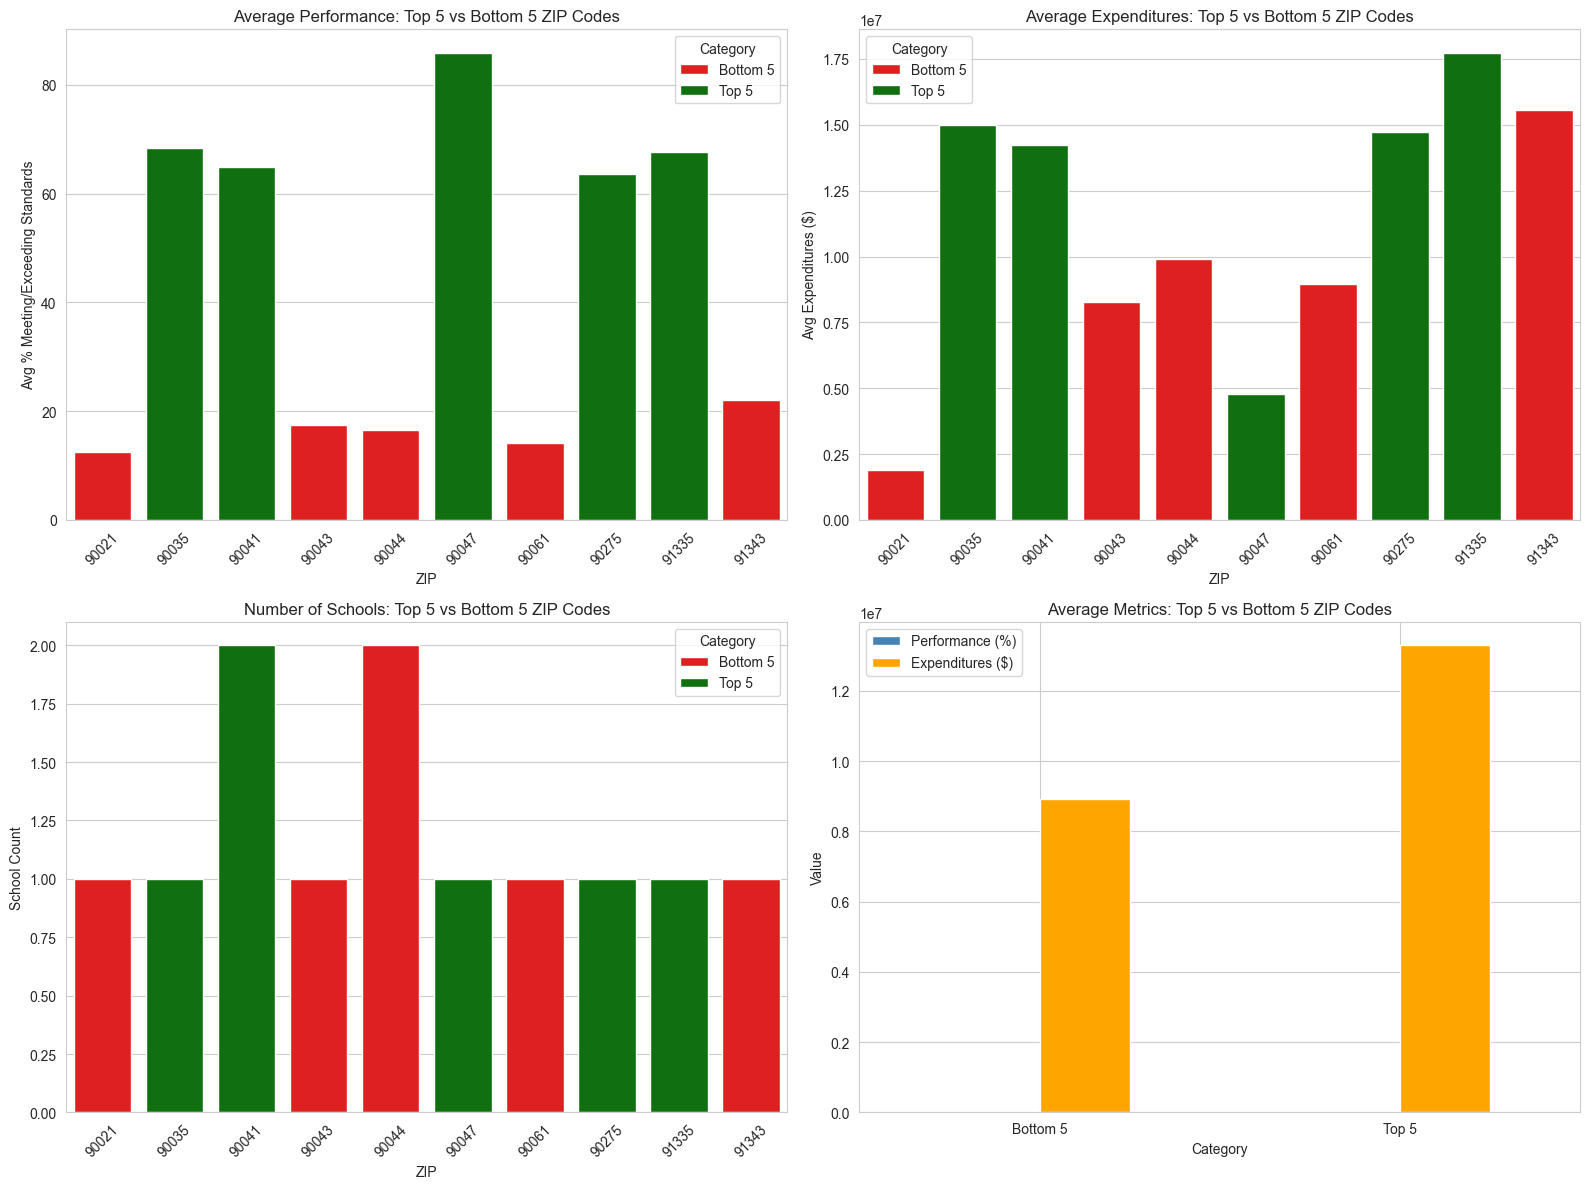


Top 5 ZIP Codes Summary:
      ZIP  Avg_Pct_Met_Above  Avg_Expenditures  School_Count
26  90047            85.9000      4.779587e+06             1
19  90035            68.3560      1.498121e+07             1
48  91335            67.6700      1.773628e+07             1
21  90041            64.9570      1.422795e+07             2
36  90275            63.5825      1.474318e+07             1

Bottom 5 ZIP Codes Summary:
      ZIP  Avg_Pct_Met_Above  Avg_Expenditures  School_Count
51  91343           22.13500       15560533.48             1
23  90043           17.38750        8256477.62             1
24  90044           16.60625        9924409.74             2
27  90061           14.22250        8952860.90             1
13  90021           12.50000        1901827.33             1


In [31]:
# Compare top 5 and bottom 5 ZIP codes
top_5_zips = zip_summary.nlargest(5, 'Avg_Pct_Met_Above')['ZIP'].values
bottom_5_zips = zip_summary.nsmallest(5, 'Avg_Pct_Met_Above')['ZIP'].values

comparison_data = zip_summary[zip_summary['ZIP'].isin(np.concatenate([top_5_zips, bottom_5_zips]))].copy()
comparison_data['Category'] = comparison_data['ZIP'].apply(
    lambda x: 'Top 5' if x in top_5_zips else 'Bottom 5'
)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Performance
sns.barplot(data=comparison_data, x='ZIP', y='Avg_Pct_Met_Above', 
            hue='Category', palette={'Top 5': 'green', 'Bottom 5': 'red'}, ax=axes[0, 0])
axes[0, 0].set_title('Average Performance: Top 5 vs Bottom 5 ZIP Codes')
axes[0, 0].set_ylabel('Avg % Meeting/Exceeding Standards')
axes[0, 0].tick_params(axis='x', rotation=45)

# Funding
sns.barplot(data=comparison_data, x='ZIP', y='Avg_Expenditures', 
            hue='Category', palette={'Top 5': 'green', 'Bottom 5': 'red'}, ax=axes[0, 1])
axes[0, 1].set_title('Average Expenditures: Top 5 vs Bottom 5 ZIP Codes')
axes[0, 1].set_ylabel('Avg Expenditures ($)')
axes[0, 1].tick_params(axis='x', rotation=45)

# School count
sns.barplot(data=comparison_data, x='ZIP', y='School_Count', 
            hue='Category', palette={'Top 5': 'green', 'Bottom 5': 'red'}, ax=axes[1, 0])
axes[1, 0].set_title('Number of Schools: Top 5 vs Bottom 5 ZIP Codes')
axes[1, 0].set_ylabel('School Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Summary statistics
summary_stats = comparison_data.groupby('Category')[['Avg_Pct_Met_Above', 'Avg_Expenditures']].mean()
summary_stats.plot(kind='bar', ax=axes[1, 1], color=['steelblue', 'orange'])
axes[1, 1].set_title('Average Metrics: Top 5 vs Bottom 5 ZIP Codes')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
axes[1, 1].legend(['Performance (%)', 'Expenditures ($)'])

plt.tight_layout()
plt.show()

print("\nTop 5 ZIP Codes Summary:")
print(zip_summary[zip_summary['ZIP'].isin(top_5_zips)][['ZIP', 'Avg_Pct_Met_Above', 'Avg_Expenditures', 'School_Count']])
print("\nBottom 5 ZIP Codes Summary:")
print(zip_summary[zip_summary['ZIP'].isin(bottom_5_zips)][['ZIP', 'Avg_Pct_Met_Above', 'Avg_Expenditures', 'School_Count']])

## 4. ZIP Code Clustering Analysis

### 4.1 K-Means Clustering by Performance and Funding

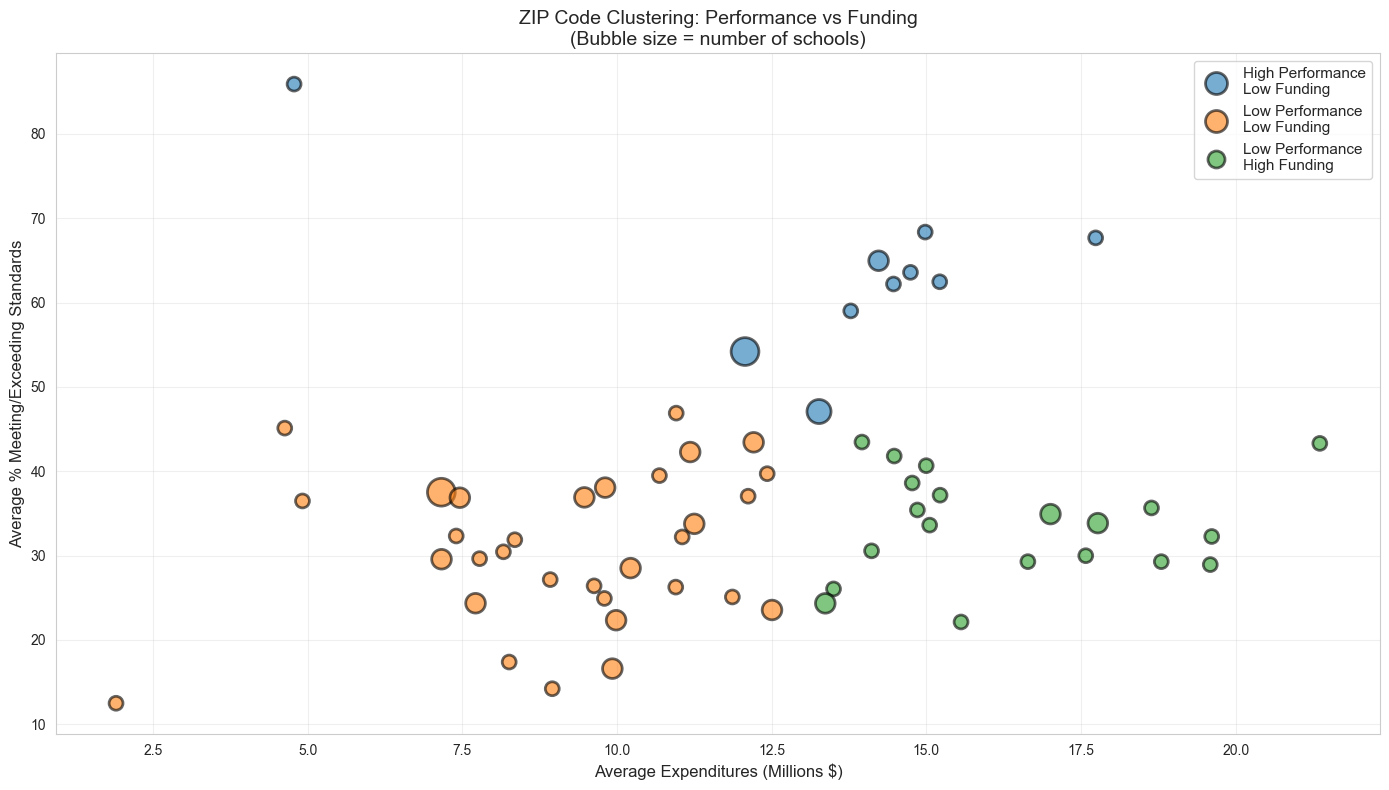


Cluster Summary:
                               ZIP  School_Count  Avg_Pct_Met_Above  \
Cluster_Name                                                          
High Performance\nLow Funding   10            16              63.54   
Low Performance\nHigh Funding   20            23              33.57   
Low Performance\nLow Funding    32            47              30.91   

                               Avg_Expenditures  
Cluster_Name                                     
High Performance\nLow Funding       13526371.62  
Low Performance\nHigh Funding       16343411.07  
Low Performance\nLow Funding         9212122.71  


In [32]:
# Prepare data for clustering
cluster_data = zip_summary[['Avg_Pct_Met_Above', 'Avg_Expenditures', 'Avg_Budget']].copy()

# Standardize for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# K-means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
zip_summary['Cluster'] = kmeans.fit_predict(cluster_scaled)

# Assign cluster names based on characteristics
cluster_means = zip_summary.groupby('Cluster')[['Avg_Pct_Met_Above', 'Avg_Expenditures']].mean()
cluster_labels = {}
for idx in cluster_means.index:
    perf = cluster_means.loc[idx, 'Avg_Pct_Met_Above']
    fund = cluster_means.loc[idx, 'Avg_Expenditures']
    
    if perf > cluster_means['Avg_Pct_Met_Above'].median():
        if fund > cluster_means['Avg_Expenditures'].median():
            cluster_labels[idx] = 'High Performance\nHigh Funding'
        else:
            cluster_labels[idx] = 'High Performance\nLow Funding'
    else:
        if fund > cluster_means['Avg_Expenditures'].median():
            cluster_labels[idx] = 'Low Performance\nHigh Funding'
        else:
            cluster_labels[idx] = 'Low Performance\nLow Funding'

zip_summary['Cluster_Name'] = zip_summary['Cluster'].map(cluster_labels)

# Visualize clusters
plt.figure(figsize=(14, 8))
for cluster_id, label in cluster_labels.items():
    cluster_data_plot = zip_summary[zip_summary['Cluster'] == cluster_id]
    plt.scatter(cluster_data_plot['Avg_Expenditures'] / 1e6, 
                cluster_data_plot['Avg_Pct_Met_Above'],
                s=cluster_data_plot['School_Count'] * 100,
                label=label, alpha=0.6, edgecolors='black', linewidth=2)

plt.xlabel('Average Expenditures (Millions $)', fontsize=12)
plt.ylabel('Average % Meeting/Exceeding Standards', fontsize=12)
plt.title('ZIP Code Clustering: Performance vs Funding\n(Bubble size = number of schools)', fontsize=14)
plt.legend(fontsize=11, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCluster Summary:")
print(zip_summary.groupby('Cluster_Name')[['ZIP', 'School_Count', 'Avg_Pct_Met_Above', 'Avg_Expenditures']].agg({
    'ZIP': 'count',
    'School_Count': 'sum',
    'Avg_Pct_Met_Above': 'mean',
    'Avg_Expenditures': 'mean'
}).round(2))

### 4.2 Cluster Characteristics

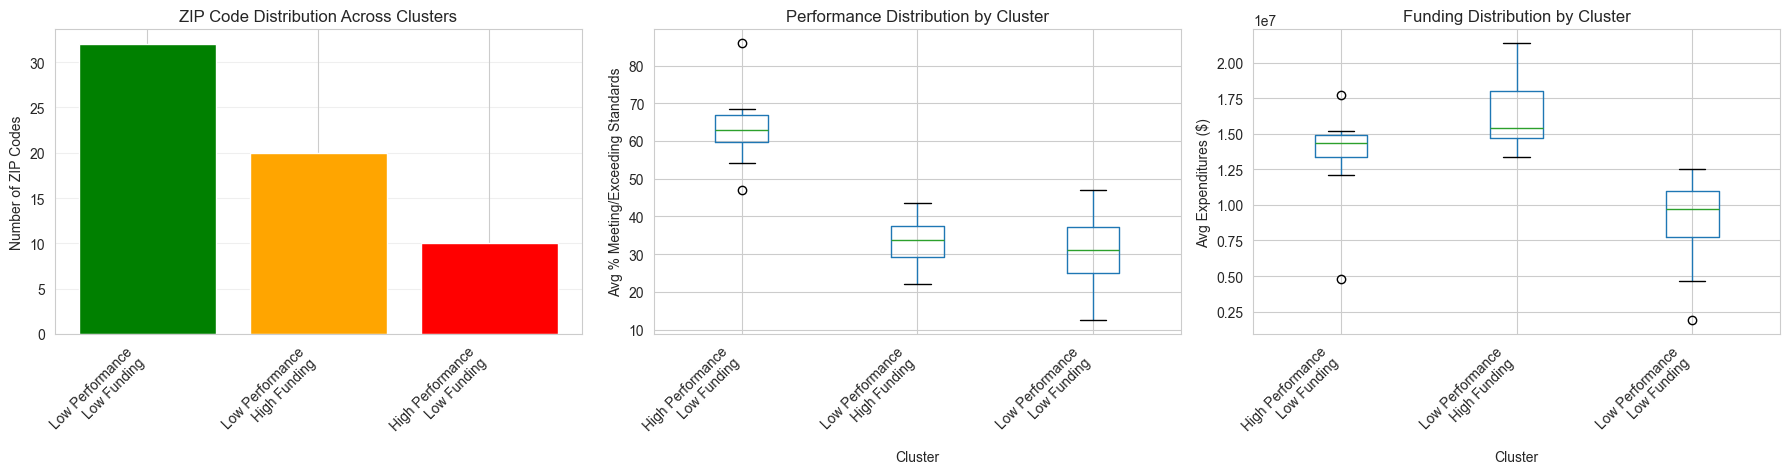


ZIP Codes by Cluster:

High Performance
Low Funding: [90047, 90035, 91335, 90041, 90275, 91602, 90005, 90034, 91344, 90745]

Low Performance
Low Funding: [91040, 90292, 91325, 90042, 90065, 90007, 90066, 90063, 91411, 90045, 90008, 90019, 90026, 90746, 91606, 91367, 90038, 90064, 91311, 91331, 91340, 90028, 90071, 91306, 90006, 90017, 90001, 90002, 90043, 90044, 90061, 90021]

Low Performance
High Funding: [90032, 90018, 90004, 90023, 91406, 90717, 90731, 91352, 90255, 90280, 91342, 90201, 90015, 90247, 91605, 91402, 91405, 90003, 90011, 91343]


In [33]:
# Detailed cluster analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution of ZIP codes per cluster
cluster_counts = zip_summary['Cluster_Name'].value_counts()
axes[0].bar(range(len(cluster_counts)), cluster_counts.values, color=['green', 'orange', 'red'])
axes[0].set_xticks(range(len(cluster_counts)))
axes[0].set_xticklabels(cluster_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Number of ZIP Codes')
axes[0].set_title('ZIP Code Distribution Across Clusters')
axes[0].grid(axis='y', alpha=0.3)

# Performance by cluster
zip_summary.boxplot(column='Avg_Pct_Met_Above', by='Cluster_Name', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Avg % Meeting/Exceeding Standards')
axes[1].set_title('Performance Distribution by Cluster')
plt.sca(axes[1])
plt.xticks(rotation=45, ha='right')
axes[1].get_figure().suptitle('')  # Remove auto-title

# Funding by cluster
zip_summary.boxplot(column='Avg_Expenditures', by='Cluster_Name', ax=axes[2])
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Avg Expenditures ($)')
axes[2].set_title('Funding Distribution by Cluster')
plt.sca(axes[2])
plt.xticks(rotation=45, ha='right')
axes[2].get_figure().suptitle('')  # Remove auto-title

plt.tight_layout()
plt.show()

# Print ZIP codes in each cluster
print("\nZIP Codes by Cluster:")
for cluster_name in zip_summary['Cluster_Name'].unique():
    zips = zip_summary[zip_summary['Cluster_Name'] == cluster_name]['ZIP'].values
    print(f"\n{cluster_name}: {list(zips)}")

## 5. Feature Correlation Analysis

### 5.1 ZIP-Level vs School-Level Correlations

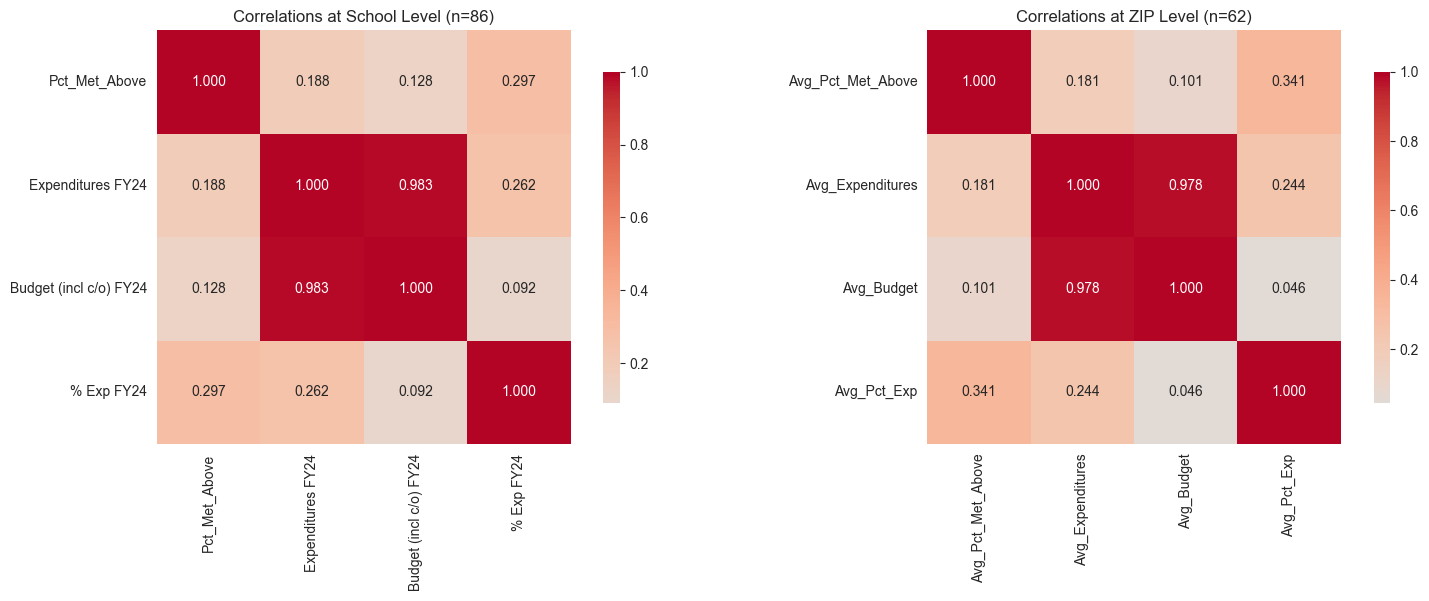


Key Insight:
School-level correlation (Expenditures vs Performance): 0.188
ZIP-level correlation (Expenditures vs Performance): 0.181

Geographic aggregation shows stronger/weaker relationships


In [34]:
# Compare correlations at different aggregation levels
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# School-level correlations
school_corr = final_clean[['Pct_Met_Above', 'Expenditures FY24', 'Budget (incl c/o) FY24', '% Exp FY24']].corr()
sns.heatmap(school_corr, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, cbar_kws={'shrink': 0.8}, ax=axes[0])
axes[0].set_title('Correlations at School Level (n=86)', fontsize=12)

# ZIP-level correlations
zip_corr = zip_summary[['Avg_Pct_Met_Above', 'Avg_Expenditures', 'Avg_Budget', 'Avg_Pct_Exp']].corr()
sns.heatmap(zip_corr, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, cbar_kws={'shrink': 0.8}, ax=axes[1])
axes[1].set_title(f'Correlations at ZIP Level (n={len(zip_summary)})', fontsize=12)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print(f"School-level correlation (Expenditures vs Performance): {school_corr.loc['Pct_Met_Above', 'Expenditures FY24']:.3f}")
print(f"ZIP-level correlation (Expenditures vs Performance): {zip_corr.loc['Avg_Pct_Met_Above', 'Avg_Expenditures']:.3f}")
print("\nGeographic aggregation shows stronger/weaker relationships")

ZIP Code Feature Importance Validation

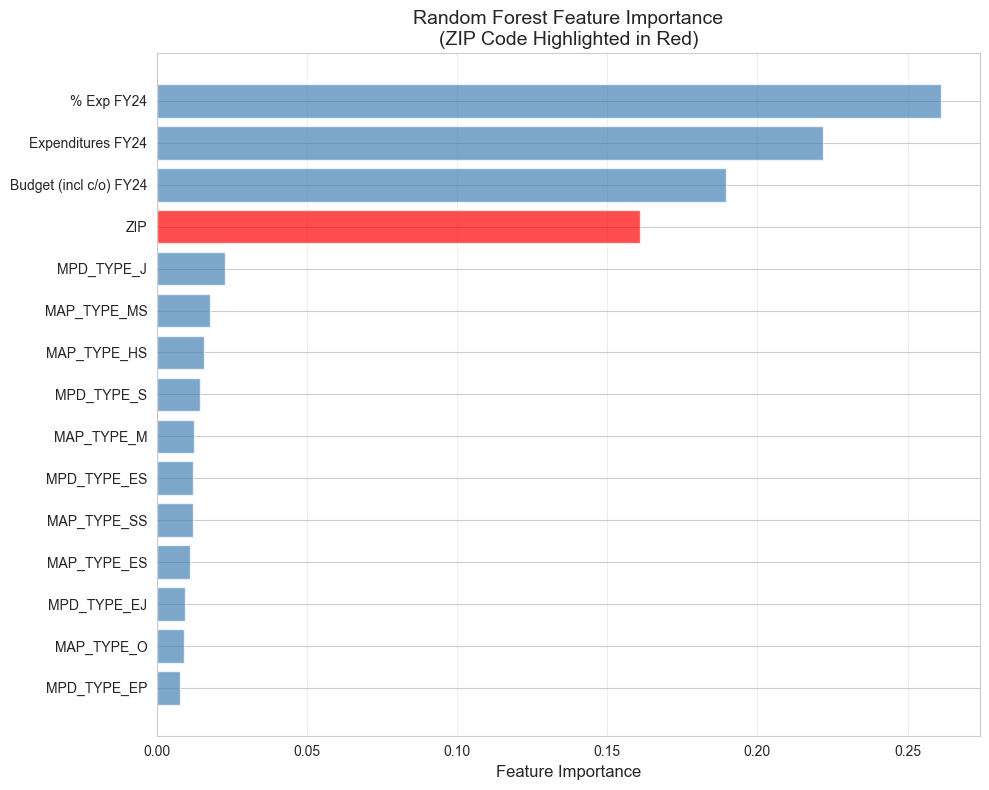

ZIP CODE FEATURE IMPORTANCE: 0.1608 (16.08%)
RANK: #4 out of 23 features

Top 10 Most Important Features:
               Feature  Importance
            % Exp FY24    0.261092
     Expenditures FY24    0.221679
Budget (incl c/o) FY24    0.189677
                   ZIP    0.160799
            MPD_TYPE_J    0.022599
           MAP_TYPE_MS    0.017662
           MAP_TYPE_HS    0.015705
            MPD_TYPE_S    0.014447
            MAP_TYPE_M    0.012443
           MPD_TYPE_ES    0.012118


In [35]:
# Recreate the model to validate ZIP importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare features
numeric_features = [
    "Budget (incl c/o) FY24",
    "Expenditures FY24",
    "% Exp FY24",
    "ZIP"
]

categorical_features = [
    "MPD_TYPE",
    "MAP_TYPE",
    "CHARTER",
    "LD"
]

X_numeric = final_clean[numeric_features].copy()
X_categorical = pd.get_dummies(final_clean[categorical_features], drop_first=True)
X = pd.concat([X_numeric, X_categorical], axis=1)
y = (final_clean["Pct_Met_Above"] >= final_clean["Pct_Met_Above"].median()).astype(int)

# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15 = feature_importance_df.head(15)
colors = ['red' if feat == 'ZIP' else 'steelblue' for feat in top_15['Feature']]
plt.barh(range(len(top_15)), top_15['Importance'], color=colors, alpha=0.7)
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest Feature Importance\n(ZIP Code Highlighted in Red)', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print ZIP importance
zip_importance = feature_importance_df[feature_importance_df['Feature'] == 'ZIP']['Importance'].values[0]
zip_rank = feature_importance_df[feature_importance_df['Feature'] == 'ZIP'].index[0] + 1

print(f"ZIP CODE FEATURE IMPORTANCE: {zip_importance:.4f} ({zip_importance*100:.2f}%)")
print(f"RANK: #{zip_rank} out of {len(feature_importance_df)} features")

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))